In [1]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(SeuratExtend))
library(anndata)
library(pheatmap)
library(RColorBrewer)
library(harmony)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

Sys.setenv(RETICULATE_REPL_PROMPT = FALSE) ### disable reticulate prompt
options(future.globals.maxSize = 64000 * 1024^2) ### prevent future error


Attaching package: ‘anndata’


The following object is masked from ‘package:SeuratObject’:

    Layers


Loading required package: Rcpp

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
### Add brain region color
cols <- read.csv("/projects//ps-renlab2/y2xie/projects/BICAN/ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region) %>% unlist

In [3]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

qcol <- read.csv("./analysis/04.clustering/cluster_manual_name.color.csv")

## Read data input

In [490]:
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')
table(rmeta$target)


 H3K27ac H3K27me3 
  339097   411980 

In [5]:
gaba <- rmeta %>% filter(class == "GABA") %>% select(subclass_corrected) %>% unlist %>% unique %>% as.character
glut <- rmeta %>% filter(class == "Glut") %>% select(subclass_corrected) %>% unlist %>% unique %>% as.character
nonn <- rmeta %>% filter(class == "NonN") %>% select(subclass_corrected) %>% unlist %>% unique %>% as.character

In [6]:
abc <- read.table("../08.conns/plot/broad_abc_filtcelltype_select_conns.txt", sep = "\t", row.names = 1, header = T)

In [7]:
paired_df <- read.csv("../06.integration/snATAC_DPT_RNA_250722.pred_subclass_match.simplify.txt", sep = '\t', header = F)
head(paired_df, 3)

,V1,V2
,<chr>,<chr>
1,ACBGM,ACBGM
2,AST,AST
3,ENDO,EC


## Calculate variance explained by structure across glia cells

In [424]:
### Use Permanova to get pseudo-R2 for structual difference
### also calculate mean silhouette
flist <- list()
for (file in list.files("permanova", pattern = "_structure_region_separability.tsv")){
    ct = gsub("([^_]+)_([^_]+)_structure_region_separability.tsv", "\\1", file)
    mark = gsub("([^_]+)_([^_]+)_structure_region_separability.tsv", "\\2", file)
    flist[[paste0(ct, "_", mark)]] <- read.table(paste0("permanova/", file), header = T, sep = "\t") %>%
    mutate(celltype = ct, mod = mark)
}

flist <- do.call(rbind, flist)

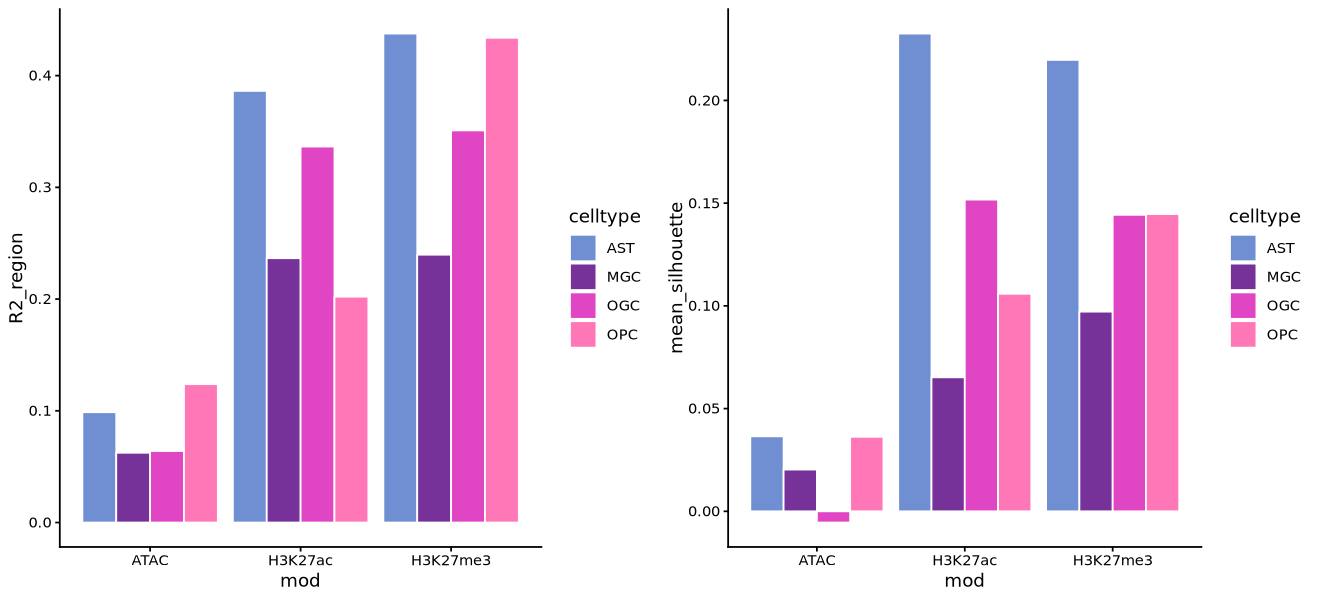

In [99]:
t1 <- flist %>%
ggplot(aes(x = mod, y = R2_region, fill = celltype)) + 
geom_col(color = "white", position = "dodge") + 
theme_classic() + 
scale_fill_manual(values = ccol2)

t2 <- flist %>%
ggplot(aes(x = mod, y = mean_silhouette, fill = celltype)) + 
geom_col(color = "white", position = "dodge") + 
theme_classic() + 
scale_fill_manual(values = ccol2)

fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)
options(repr.plot.width = 11, repr.plot.height = 5)
fig1

In [117]:
### Also calculate Permanova to get pseudo-R2 for region difference 
### mixing is expected bc dominance of by cortical regions
flist <- list()
for (file in list.files("permanova", pattern = "_region_region_separability.tsv")){
    ct = gsub("([^_]+)_([^_]+)_region_region_separability.tsv", "\\1", file)
    mark = gsub("([^_]+)_([^_]+)_region_region_separability.tsv", "\\2", file)
    flist[[paste0(ct, "_", mark)]] <- read.table(paste0("permanova/", file), header = T, sep = "\t") %>%
    mutate(celltype = ct, mod = mark)
}

flist <- do.call(rbind, flist)

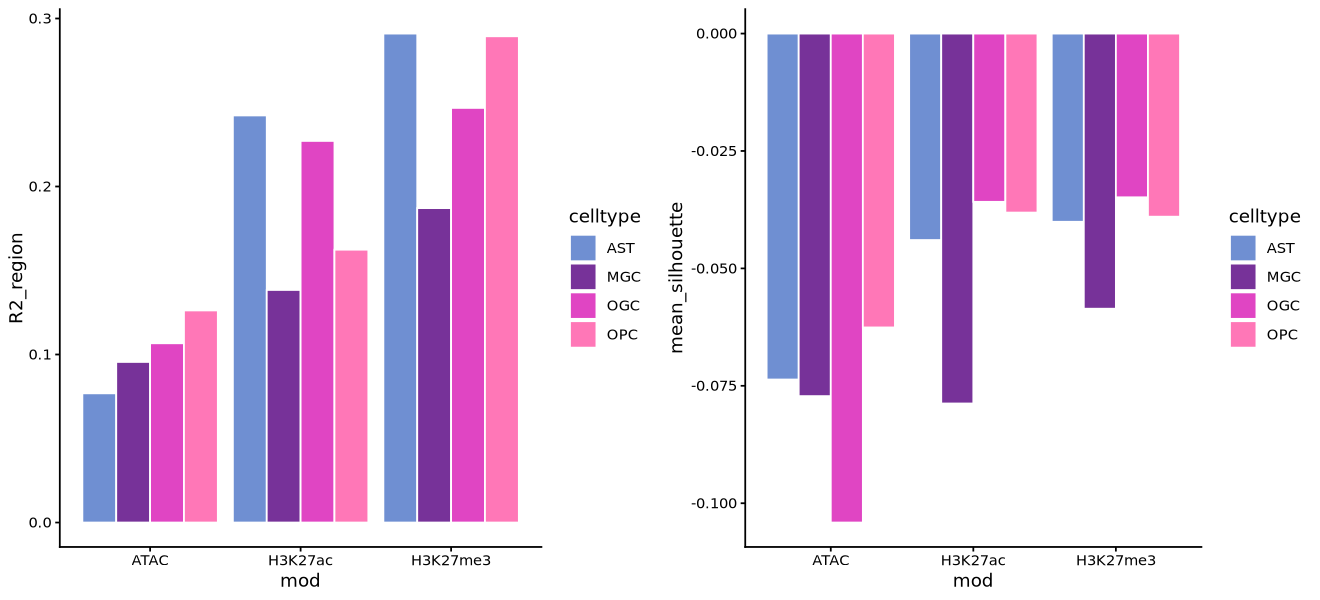

In [118]:
t1 <- flist %>%
ggplot(aes(x = mod, y = R2_region, fill = celltype)) + 
geom_col(color = "white", position = "dodge") + 
theme_classic() + 
scale_fill_manual(values = ccol2)

t2 <- flist %>%
ggplot(aes(x = mod, y = mean_silhouette, fill = celltype)) + 
geom_col(color = "white", position = "dodge") + 
theme_classic() + 
scale_fill_manual(values = ccol2)

fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)
options(repr.plot.width = 11, repr.plot.height = 5)
fig1

## From UMAP: clear separation are observed for celltypes between hindbrain and forebrain. Run DE for all

In [134]:
flist <- list()
for (ct in c("OGC", "OPC", "MGC", "AST")){
    flist2 <- list()
    for (file in list.files(paste0("DESeq/", ct))){
        fname = gsub("structure__edgeR_([^_]+)_vs_all_groups.xls", "\\1", file)
        flist2[[file]] <- read.table(paste0("DESeq/", ct, "/", file), header = T) %>% 
        mutate(region = fname, celltype = ct) %>% 
        tibble::rownames_to_column("gene")
    }
    flist2 <- do.call(rbind, flist2)
    flist[[ct]] <- flist2
}

flist <- do.call(rbind, flist)

In [209]:
elist <- list()
for (ct in c("OGC", "OPC", "MGC", "AST")){
    elist[[paste0(ct, "_H3K27ac")]] <- read.csv(paste0("DESeq/", ct, "/structure_H3K27ac_15kb.csv"), header = T) %>% 
    mutate(target = "H3K27ac", celltype = ct)
    elist[[paste0(ct, "_H3K27me3")]] <- read.csv(paste0("DESeq/", ct, "/structure_H3K27me3_15kb.csv"), header = T) %>% 
    mutate(target = "H3K27me3", celltype = ct)
}

elist <- do.call(rbind, elist)

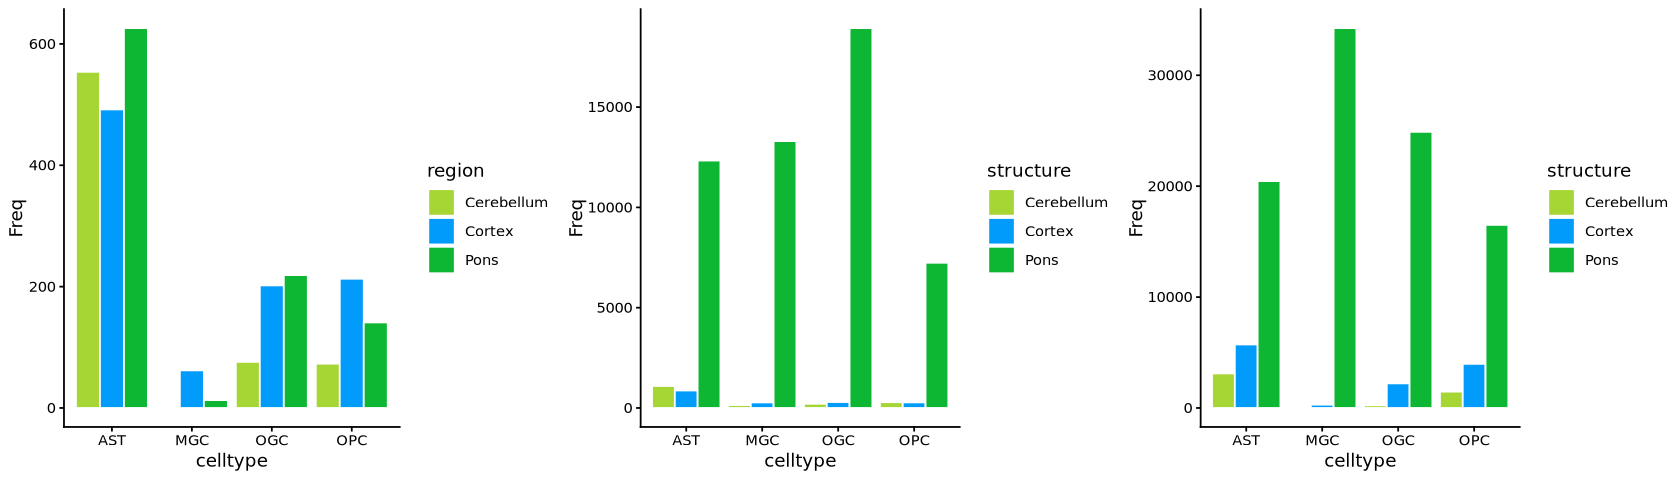

In [228]:
t1 <- flist %>% filter(FDR < 0.01, logFC >= 1) %>% 
dplyr::select(region, celltype) %>% table %>%
as.data.frame %>%
ggplot(aes(x = celltype, y = Freq, fill = region)) +
geom_col(position = "dodge", color = "white") + 
theme_classic() + scale_fill_manual(values = col1) #+ scale_y_log10()

t2 <- elist %>% filter(target == "H3K27ac") %>%
filter(adjusted.p.value < 0.05, log2.fold_change. >= 1) %>% 
dplyr::select(structure, celltype) %>% table %>%
as.data.frame %>%
ggplot(aes(x = celltype, y = Freq, fill = structure)) +
geom_col(position = "dodge", color = "white") + 
theme_classic() + scale_fill_manual(values = col1) #+ scale_y_log10()

t3 <- elist %>% filter(target == "H3K27me3") %>%
filter(adjusted.p.value < 0.05, log2.fold_change. >= 1) %>% 
dplyr::select(structure, celltype) %>% table %>%
as.data.frame %>%
ggplot(aes(x = celltype, y = Freq, fill = structure)) +
geom_col(position = "dodge", color = "white") + 
theme_classic() + scale_fill_manual(values = col1) #+ scale_y_log10()

fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
options(repr.plot.width = 14, repr.plot.height = 4)
fig1

### Plot genes with differential gene scores

In [247]:
gscore <- qs::qread("../04.clustering/01.DNA/MiniAtlas_H3K27ac_merged_dual_filt_clean_250722_cluster_manual_name_geneScore.qs")
system("mkdir ../04.clustering/01.DNA/subclass_genescore")
for (f in unique(gscore$subclass_corrected)){
    vcell <- gscore@meta.data %>% filter(subclass_corrected == f) %>% rownames
    tmp <- subset(gscore, cells = vcell)
    qs::qsave(tmp, paste0("../04.clustering/01.DNA/subclass_genescore/MiniAtlas_H3K2ac_merged_dual_filt_clean_250722_", f, "_geneScore.qs"))
}

In [246]:
gscore <- qs::qread("../04.clustering/01.DNA/MiniAtlas_H3K27me3_merged_dual_filt_clean_250722_cluster_manual_name_geneScore.qs")
system("mkdir ../04.clustering/01.DNA/subclass_genescore")
for (f in unique(gscore$subclass_corrected)){
    vcell <- gscore@meta.data %>% filter(subclass_corrected == f) %>% rownames
    tmp <- subset(gscore, cells = vcell)
    qs::qsave(tmp, paste0("../04.clustering/01.DNA/subclass_genescore/MiniAtlas_H3K27me3_merged_dual_filt_clean_250722_", f, "_geneScore.qs"))
}

In [258]:
### also plot genescore: use gene as a standardized measurement...
elist2 <- list()
for (ct in c("OGC", "OPC", "MGC", "AST")){
    flist2 <- list()
    for (file in list.files(paste0("DESeq/", ct), pattern = "structure_gs.*")){
        target = gsub("structure_gs-([^_]+)__edgeR_([^_]+)_vs_all_groups.xls", "\\1", file)
        fname = gsub("structure_gs-([^_]+)__edgeR_([^_]+)_vs_all_groups.xls", "\\2", file)
        flist2[[file]] <- read.table(paste0("DESeq/", ct, "/", file), header = T) %>% 
        mutate(region = fname, celltype = ct, mod = target) %>% 
        tibble::rownames_to_column("gene")
    }
    flist2 <- do.call(rbind, flist2)
    elist2[[ct]] <- flist2
}

elist2 <- do.call(rbind, elist2)

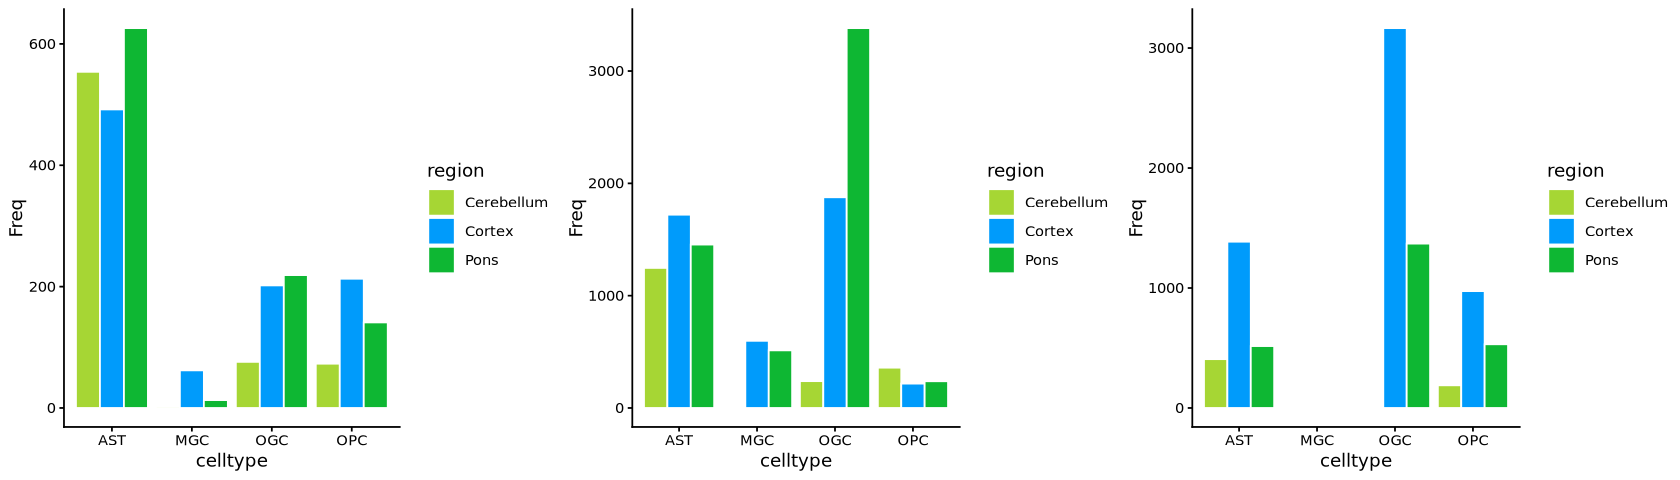

In [288]:
t2 <- elist2 %>% filter(mod == "H3K27ac") %>%
filter(FDR < 0.01, logFC >= 1) %>% 
dplyr::select(region, celltype) %>% table %>%
as.data.frame %>%
ggplot(aes(x = celltype, y = Freq, fill = region)) +
geom_col(position = "dodge", color = "white") + 
theme_classic() + scale_fill_manual(values = col1) #+ scale_y_log10()

t3 <- elist2 %>% filter(mod == "H3K27me3") %>%
filter(FDR < 0.01, logFC >= 1) %>% 
dplyr::select(region, celltype) %>% table %>%
as.data.frame %>%
ggplot(aes(x = celltype, y = Freq, fill = region)) +
geom_col(position = "dodge", color = "white") + 
theme_classic() + scale_fill_manual(values = col1) #+ scale_y_log10()

fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
options(repr.plot.width = 14, repr.plot.height = 4)
fig1

## Glia example: AST

In [94]:
sc <- "AST"
d1 <- read_h5ad(paste0("../04.clustering/01.DNA/03.l3_clustering/snapatac2/MiniAtlas_H3K27ac_merged_dual_filt_clean_corrected_250529_", sc, ".h5ad"))
d1$obs[,c("UMAP.1", "UMAP.2")] <- d1$obsm$X_umap

d2 <- read_h5ad(paste0("../04.clustering/01.DNA/03.l3_clustering/snapatac2/MiniAtlas_H3K27me3_merged_dual_filt_clean_corrected_250529_", sc, ".h5ad"))
d2$obs[,c("UMAP.1", "UMAP.2")] <- d2$obsm$X_umap

robj <- qs::qread(paste0("../04.clustering/02.RNA/03.l3_clustering//02.seurat_object/old/MiniAtlas_RNA_merged_dual_filt_250520_", sc, ".qs"))
rumap <- merge(robj@meta.data, as.data.frame(robj@reductions$umap@cell.embeddings), by = 0) %>%
tibble::column_to_rownames('Row.names')

In [95]:
mtx <- d1$obsm$X_umap
rownames(mtx) <- d1$obs$rna_bc
robj[["k27ac_umap"]] <- CreateDimReducObject(mtx, key = "acUMAP")

mtx <- d2$obsm$X_umap
rownames(mtx) <- d2$obs$rna_bc
robj[["k27me3_umap"]] <- CreateDimReducObject(mtx, key = "meUMAP")

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from acUMAP to acUMAP_”
Warning message:
“No columnames present in cell embeddings, setting to 'acUMAP_1:2'”
Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from meUMAP to meUMAP_”
Warning message:
“No columnames present in cell embeddings, setting to 'meUMAP_1:2'”


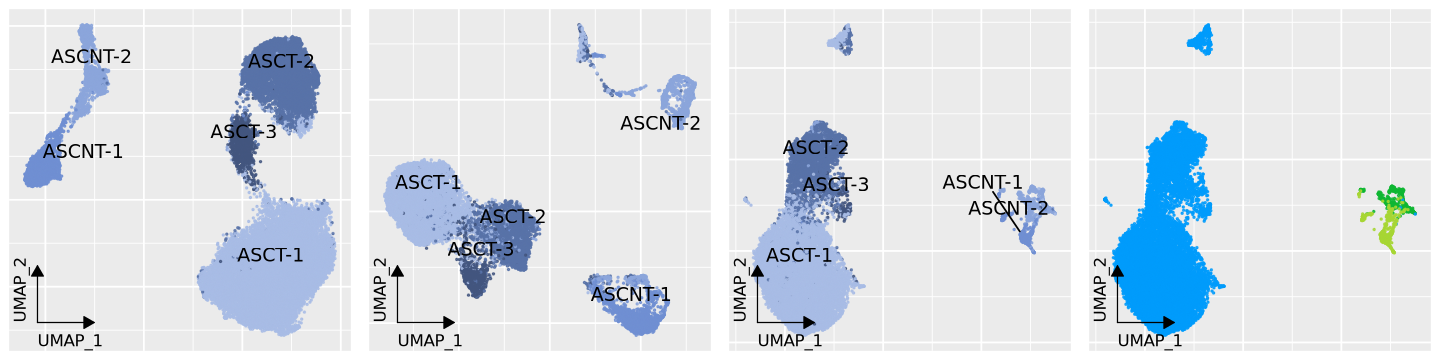

In [17]:
qcol <- c('#6f8fd2','#8ba5db','#a8bbe4','#5872a8','#42557e')
rumap$cluster_manual_name <- rmeta[rownames(rumap),]$cluster_manual_name
d1$obs$cluster_manual_name <- rmeta[d1$obs$rna_bc,]$cluster_manual_name
d2$obs$cluster_manual_name <- rmeta[d2$obs$rna_bc,]$cluster_manual_name

centroids <- rumap %>% 
group_by(cluster_manual_name) %>% summarize(umap_1 = mean(umap_1), umap_2 = mean(umap_2))

t1 <- rumap %>%
ggplot(aes(x = umap_1, y = umap_2, color = cluster_manual_name)) + 
geom_point(size = 0.3, alpha = 0.8) + 
ggrepel::geom_text_repel(data = centroids, aes(x = umap_1, y = umap_2, label = cluster_manual_name), 
                         size = 4, color = "black", vjust = 1.5, hjust = 0.5) +
theme_umap_arrows() + 
scale_color_manual(values = qcol) + NoLegend()

centroids <- d1$obs %>% group_by(cluster_manual_name) %>% summarize(umap_1 = mean(UMAP.1), umap_2 = mean(UMAP.2))
t2 <- d1$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = cluster_manual_name)) + 
geom_point(size = 0.3, alpha = 0.8) + 
ggrepel::geom_text_repel(data = centroids, aes(x = umap_1, y = umap_2, label = cluster_manual_name), 
                         size = 4, color = "black", vjust = 1.5, hjust = 0.5) +
theme_umap_arrows() + 
scale_color_manual(values = qcol) + NoLegend()

centroids <- d2$obs %>% group_by(cluster_manual_name) %>% summarize(umap_1 = mean(UMAP.1), umap_2 = mean(UMAP.2))
t3 <- d2$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = cluster_manual_name)) + 
geom_point(size = 0.3, alpha = 0.8) + 
ggrepel::geom_text_repel(data = centroids, aes(x = umap_1, y = umap_2, label = cluster_manual_name), 
                         size = 4, color = "black", vjust = 1.5, hjust = 0.5) +
theme_umap_arrows() + 
scale_color_manual(values = qcol) + NoLegend()

t4 <- d2$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = structure)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_umap_arrows() + 
scale_color_manual(values = col1) + NoLegend()

options(repr.plot.width = 12, repr.plot.height = 3)
fig1 <- cowplot::plot_grid(t1, t2, t3, t4, ncol = 4)
fig1

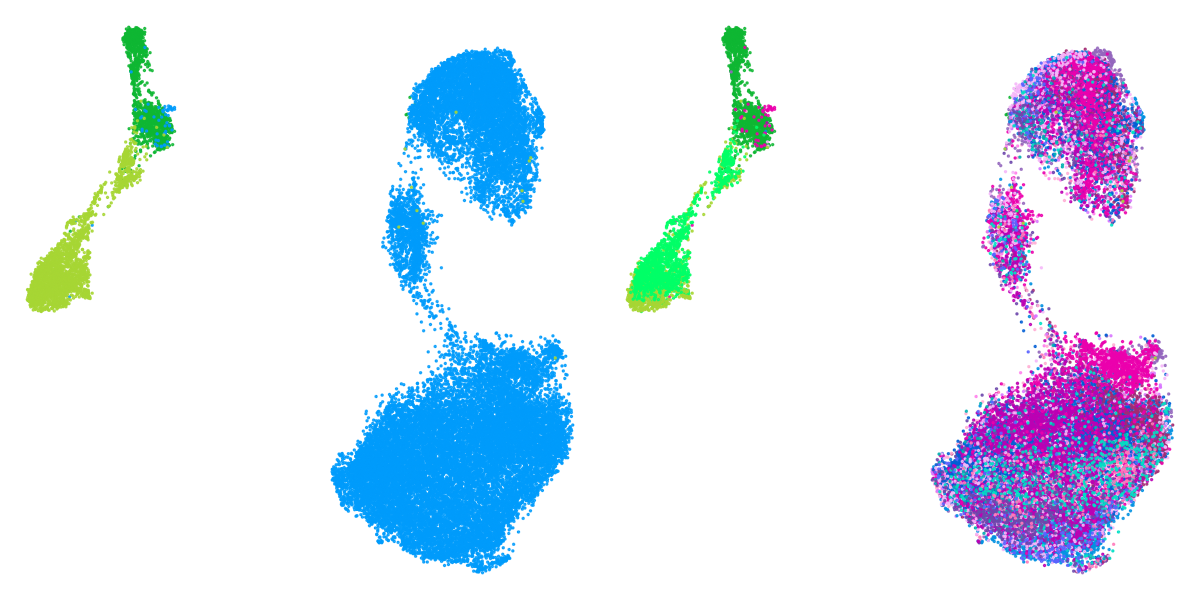

In [114]:
t1 <- rumap %>%
ggplot(aes(x = umap_1, y = umap_2, color = structure)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_void() + 
scale_color_manual(values = col1) + NoLegend()

t2 <- rumap %>%
ggplot(aes(x = umap_1, y = umap_2, color = region)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_void() + 
scale_color_manual(values = col2) + NoLegend()

options(repr.plot.width = 10, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)
fig1

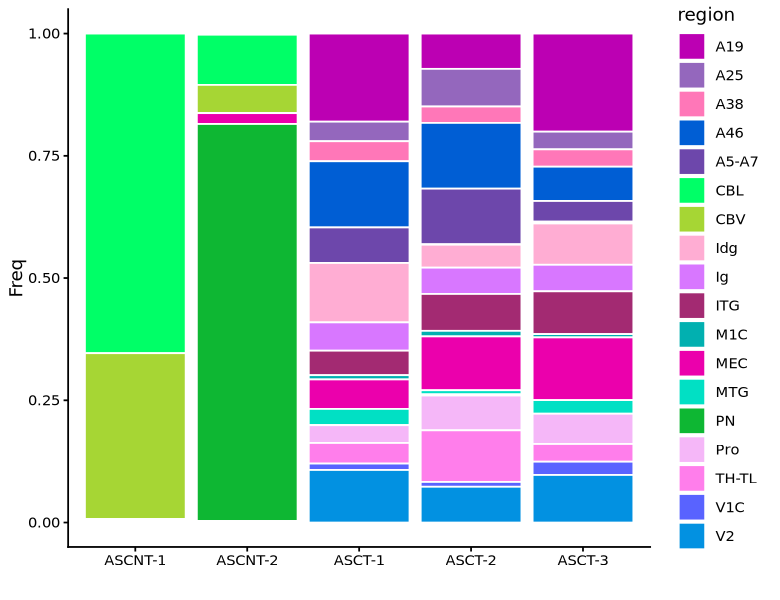

In [132]:
t1 <- robj@meta.data[,c("region", "cluster_manual_name")] %>%
table %>% as.data.frame %>% 
ggplot(aes(x = cluster_manual_name, y = Freq, fill = region)) + 
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + 
scale_fill_manual(values = col2)

options(repr.plot.width = 6.5, repr.plot.height = 5)
t1

ggsave(t1, filename = paste0("../Figure/FIG_", sc, "_cluster_manual_name_by_region.pdf"), dpi = 300, height = 5, width = 10)

### Forebrain vs hindbrain AST: inspect differential cCREs

In [27]:
system("mkdir -p AST_heterogenity/DESeq")
robj$ct <- NA
robj@meta.data[robj$cluster_manual %in% c("ASCT-1", "ASCT-2", "ASCT-3"),]$ct <- "ASCT"
robj@meta.data[robj$cluster_manual %in% c("ASCNT-1", "ASCNT-2"),]$ct <- "ASCNT"

### split into two pseudoreplicates
rmeta <- robj@meta.data %>% mutate(donor = sample(c("A","B"), n(), replace = TRUE))

# collect cells to keep (balanced by donor)
regions <- sort(unique(rmeta$ct))
dsel <- unique(rmeta$donor)
cells_per_donor_cap <- 500 ### try to balance donor

cells_keep <- unlist(lapply(regions, function(r) {
    unlist(lapply(dsel, function(dn) {
    ids <- rownames(rmeta)[rmeta$ct == r & rmeta$donor == dn]
    if (is.finite(cells_per_donor_cap) && length(ids) > cells_per_donor_cap) {
      sample(ids, cells_per_donor_cap, replace = F)
    } else ids
  }))
}), use.names = FALSE)

mmg <- subset(robj, cells = cells_keep)
mmg$donor <- rmeta[colnames(mmg),]$donor

exprr <- AggregateExpression(mmg, group.by = c("donor", "ct"))
designs = stringr::str_split_fixed(colnames(exprr$RNA), n = 2, pattern = "_") %>% as.data.frame %>% setNames(c("sample", "group"))
rownames(designs) <- colnames(exprr$RNA)
edgeR_ovr_pairwise(exprr$RNA, sample = designs, group = "group", pairwise = T,
          prefix = paste0("AST_heterogenity/DESeq/AST_"))

Checking sample order matches counts columns...

Creating DGEList...

Running one-vs-rest contrasts...

Running pairwise contrasts...

Done.



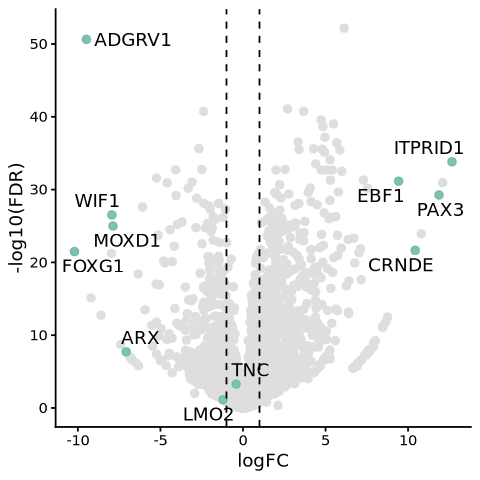

In [122]:
genede <- read.table("AST_heterogenity/DESeq/AST__edgeR_ASCNT_vs_ASCT.tsv")
qgene <- c("ITPRID1", "PAX3", "CRNDE", "EBF1", "FOXG1", "ADGRV1", "MOXD1", "ARX", "WIF1", "LMO2", "TNC")
t1 <- genede %>%
ggplot(aes(x = logFC, y = -log10(FDR))) + 
geom_point(alpha = 1, size = 2, color = "#DEDEDE") + 
geom_point(data = genede[intersect(qgene, rownames(genede)), ], 
           aes(x = logFC, y = -log10(FDR)), 
           alpha = 0.7, size = 2, color = "#59b4a2") + 
ggrepel::geom_text_repel(data = genede[qgene,] %>% tibble::rownames_to_column("gene"),
                         aes(x = logFC, y = -log10(FDR), label = gene), # position = ggrepel::position_nudge_repel(x = 4, y = 4)
                         ) + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + 
theme_classic()

options(repr.plot.width = 4, repr.plot.height = 4)
t1

ggsave(t1, filename = "../Figure/AST_ASCNT_vs_ASCT_DEG.pdf", dpi = 300, height = 5, width = 5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


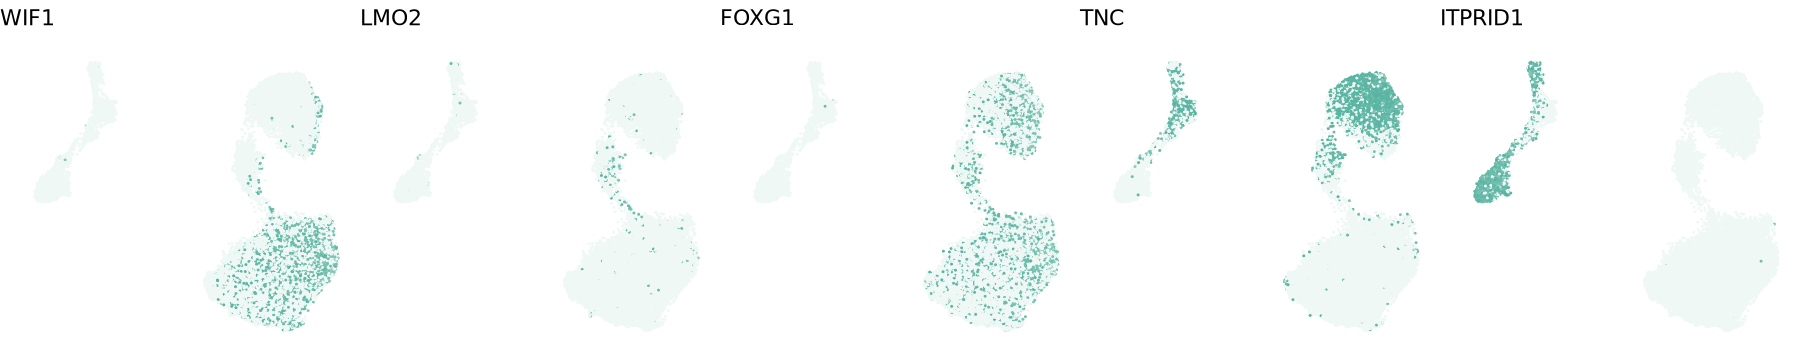

In [121]:
# "WIF1", "LMO2", "TNC" from Siletti
fig1 <- FeaturePlot(robj, features = c("WIF1", "LMO2", "FOXG1", "TNC", "ITPRID1"), ncol = 5) & scale_color_gradientn(colours = c("#eff8f5", "#59b4a2"), limits = c(0, 7), oob = squish) & theme_void() & NoLegend()

options(repr.plot.width = 15, repr.plot.height = 3)
fig1
ggsave(fig1, filename = paste0("../Figure/FIG", sc, "_UMAP_featureplot.png"), dpi = 300, height = 3, width = 15)

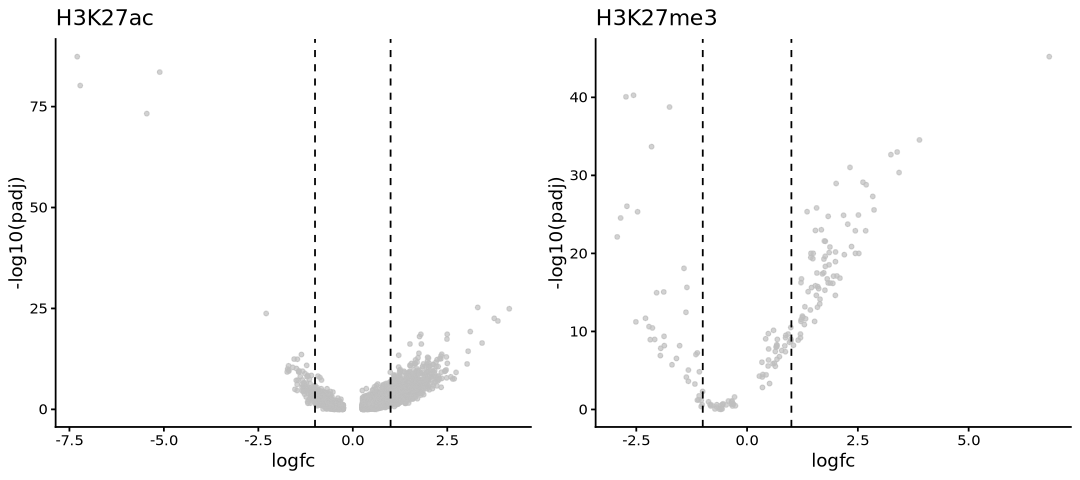

In [34]:
acde <- read.csv("AST_heterogenity/H3K27ac_ASCT_ASCNT.csv", row.names = 1) %>% 
setNames(c("feature", "logfc", "pval", "padj"))

t1 <- acde %>% 
ggplot(aes(x = logfc, y = -log10(padj))) + 
geom_point(alpha = 0.7, size = 1, color = "grey") + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + ggtitle("H3K27ac") + 
theme_classic()

me3de <- read.csv("AST_heterogenity/H3K27me3_ASCT_ASCNT.csv", row.names = 1) %>% 
setNames(c("feature", "logfc", "pval", "padj"))

t2 <- me3de %>% 
ggplot(aes(x = logfc, y = -log10(padj))) + 
geom_point(alpha = 0.7, size = 1, color = "grey") + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + ggtitle("H3K27me3") + 
theme_classic()

options(repr.plot.width = 9, repr.plot.height = 4)
cowplot::plot_grid(t1, t2, ncol = 2)

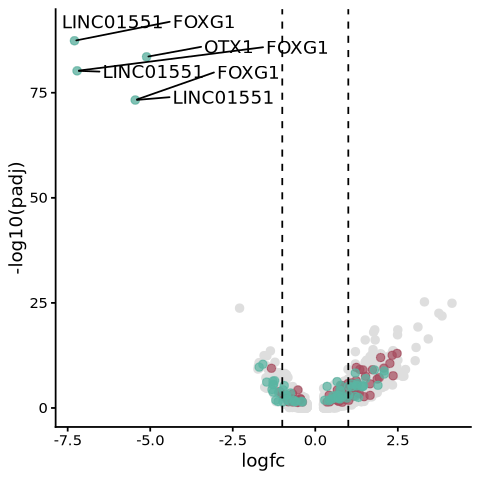

In [85]:
### Plot some features to help visualize
qfeature1 <- genede %>% filter(FDR < 0.01, logFC >= 1) %>% rownames
qfeature2 <- genede %>% filter(FDR < 0.01, logFC <= -1) %>% rownames
tmp <- abc %>% filter(celltype == "AST") %>%
filter(TargetGene %in% c(qfeature1, qfeature2))

qry1 <- abc %>% filter(celltype == "AST") %>% filter(TargetGene %in% qfeature1) %>% select(range) %>% unlist %>% as.character
qry2 <- abc %>% filter(celltype == "AST") %>% filter(TargetGene %in% qfeature2) %>% select(range) %>% unlist %>% as.character

t1 <- acde %>% 
ggplot(aes(x = logfc, y = -log10(padj))) + 
geom_point(alpha = 1, size = 2, color = "#DEDEDE") + 
geom_point(data = acde %>% filter(feature %in% qry1) %>% filter(padj < 0.05), 
           aes(x = logfc, y = -log10(padj)), 
           alpha = 0.7, size = 2, color = "#a64b5d") + 
geom_point(data = acde %>% filter(feature %in% qry2) %>% filter(padj < 0.05), 
           aes(x = logfc, y = -log10(padj)), 
           alpha = 0.7, size = 2, color = "#59b4a2") + 
ggrepel::geom_text_repel(data = merge(tmp, acde, by.x = "range", by.y = "feature") %>% filter(logfc <= -3),
                         aes(x = logfc, y = -log10(padj), label = TargetGene), 
                         position = ggrepel::position_nudge_repel(x = 3, y = 3)) + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + 
theme_classic()

options(repr.plot.width = 4, repr.plot.height = 4)
t1

ggsave(t1, filename = "../Figure/AST_ASCNT_vs_ASCT_H3K27ac_DA_ccre.pdf", dpi = 300, height = 5, width = 5)

## Glia example: OGC

In [250]:
sc <- "OGC"
d0 <- read_h5ad(paste0("../../ref/hba_ATAC/subclass_matched_region/snATAC_matched_MiniAtlas_region_", sc, ".h5ad"))
d0$obs[,c("UMAP.1", "UMAP.2")] <- d0$obsm$X_umap

d1 <- read_h5ad(paste0("../04.clustering/01.DNA/03.l3_clustering/snapatac2/MiniAtlas_H3K27ac_merged_dual_filt_clean_corrected_250529_", sc, ".h5ad"))
d1$obs[,c("UMAP.1", "UMAP.2")] <- d1$obsm$X_umap

d2 <- read_h5ad(paste0("../04.clustering/01.DNA/03.l3_clustering/snapatac2/MiniAtlas_H3K27me3_merged_dual_filt_clean_corrected_250529_", sc, ".h5ad"))
d2$obs[,c("UMAP.1", "UMAP.2")] <- d2$obsm$X_umap

robj <- qs::qread(paste0("../04.clustering/02.RNA/03.l3_clustering//02.seurat_object/old/MiniAtlas_RNA_merged_dual_filt_250520_", sc, ".qs"))
rumap <- merge(robj@meta.data, as.data.frame(robj@reductions$umap@cell.embeddings), by = 0) %>%
tibble::column_to_rownames('Row.names')

In [436]:
system("mkdir OGC_heterogenity/DESeq")
exprr <- AggregateExpression(robj, group.by = c("donor", "structure"))
designs = stringr::str_split_fixed(colnames(exprr$RNA), n = 2, pattern = "_") %>% as.data.frame %>% setNames(c("sample", "group"))
rownames(designs) <- colnames(exprr$RNA)
run.edgeR(exprr$RNA, sample = designs, group = "group", pairwise = T,
          prefix = paste0("OGC_heterogenity/DESeq/OGC_structure_"))

now creating DGE class for edgeR...
now performing glmLRT for individual clusters...
cluster: Cerebellum
cluster: Cerebellum finish.
Now calculate pairwise test for cluster: Cerebellum
cluster: Cortex
cluster: Cortex finish.
Now calculate pairwise test for cluster: Cortex
cluster: Pons
cluster: Pons finish.
Now calculate pairwise test for cluster: Pons


In [251]:
mtx <- d1$obsm$X_umap
rownames(mtx) <- d1$obs$rna_bc
robj[["k27ac_umap"]] <- CreateDimReducObject(mtx, key = "acUMAP")

mtx <- d2$obsm$X_umap
rownames(mtx) <- d2$obs$rna_bc
robj[["k27me3_umap"]] <- CreateDimReducObject(mtx, key = "meUMAP")

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from acUMAP to acUMAP_”
Warning message:
“No columnames present in cell embeddings, setting to 'acUMAP_1:2'”
Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from meUMAP to meUMAP_”
Warning message:
“No columnames present in cell embeddings, setting to 'meUMAP_1:2'”


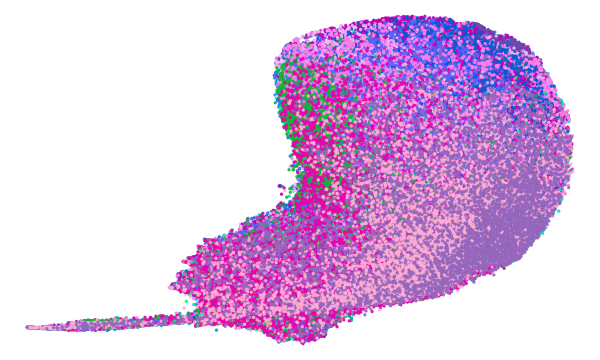

In [36]:
t1 <- d0$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = `Brain region`)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_void() + 
scale_color_manual(values = col2) + NoLegend()

options(repr.plot.width = 5, repr.plot.height = 3)
t1

ggsave(t1, filename = paste0("../Figure/FIG", sc, "_ATAC_UMAP_region_250722.png"), dpi = 300, height = 5, width = 5)

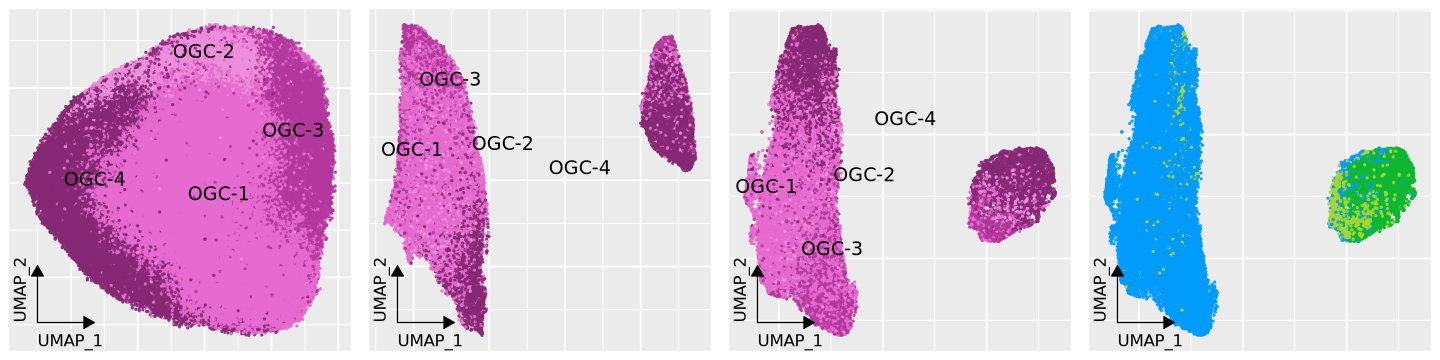

In [146]:
qcol <- c('#e66acf', '#ec8fdb', '#b3379c', '#862975')
rumap$cluster_manual_name <- rmeta[rownames(rumap),]$cluster_manual_name
d1$obs$cluster_manual_name <- rmeta[d1$obs$rna_bc,]$cluster_manual_name
d2$obs$cluster_manual_name <- rmeta[d2$obs$rna_bc,]$cluster_manual_name

centroids <- rumap %>% 
group_by(cluster_manual_name) %>% summarize(umap_1 = mean(umap_1), umap_2 = mean(umap_2))

t1 <- rumap %>%
ggplot(aes(x = umap_1, y = umap_2, color = cluster_manual_name)) + 
geom_point(size = 0.3, alpha = 0.8) + 
ggrepel::geom_text_repel(data = centroids, aes(x = umap_1, y = umap_2, label = cluster_manual_name), 
                         size = 4, color = "black", vjust = 1.5, hjust = 0.5) +
theme_umap_arrows() + 
scale_color_manual(values = qcol) + NoLegend()

centroids <- d1$obs %>% group_by(cluster_manual_name) %>% summarize(umap_1 = mean(UMAP.1), umap_2 = mean(UMAP.2))
t2 <- d1$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = cluster_manual_name)) + 
geom_point(size = 0.3, alpha = 0.8) + 
ggrepel::geom_text_repel(data = centroids, aes(x = umap_1, y = umap_2, label = cluster_manual_name), 
                         size = 4, color = "black", vjust = 1.5, hjust = 0.5) +
theme_umap_arrows() + 
scale_color_manual(values = qcol) + NoLegend()

centroids <- d2$obs %>% group_by(cluster_manual_name) %>% summarize(umap_1 = mean(UMAP.1), umap_2 = mean(UMAP.2))
t3 <- d2$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = cluster_manual_name)) + 
geom_point(size = 0.3, alpha = 0.8) + 
ggrepel::geom_text_repel(data = centroids, aes(x = umap_1, y = umap_2, label = cluster_manual_name), 
                         size = 4, color = "black", vjust = 1.5, hjust = 0.5) +
theme_umap_arrows() + 
scale_color_manual(values = qcol) + NoLegend()

t4 <- d2$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = structure)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_umap_arrows() + 
scale_color_manual(values = col1) + NoLegend()

options(repr.plot.width = 12, repr.plot.height = 3)
fig1 <- cowplot::plot_grid(t1, t2, t3, t4, ncol = 4)
fig1

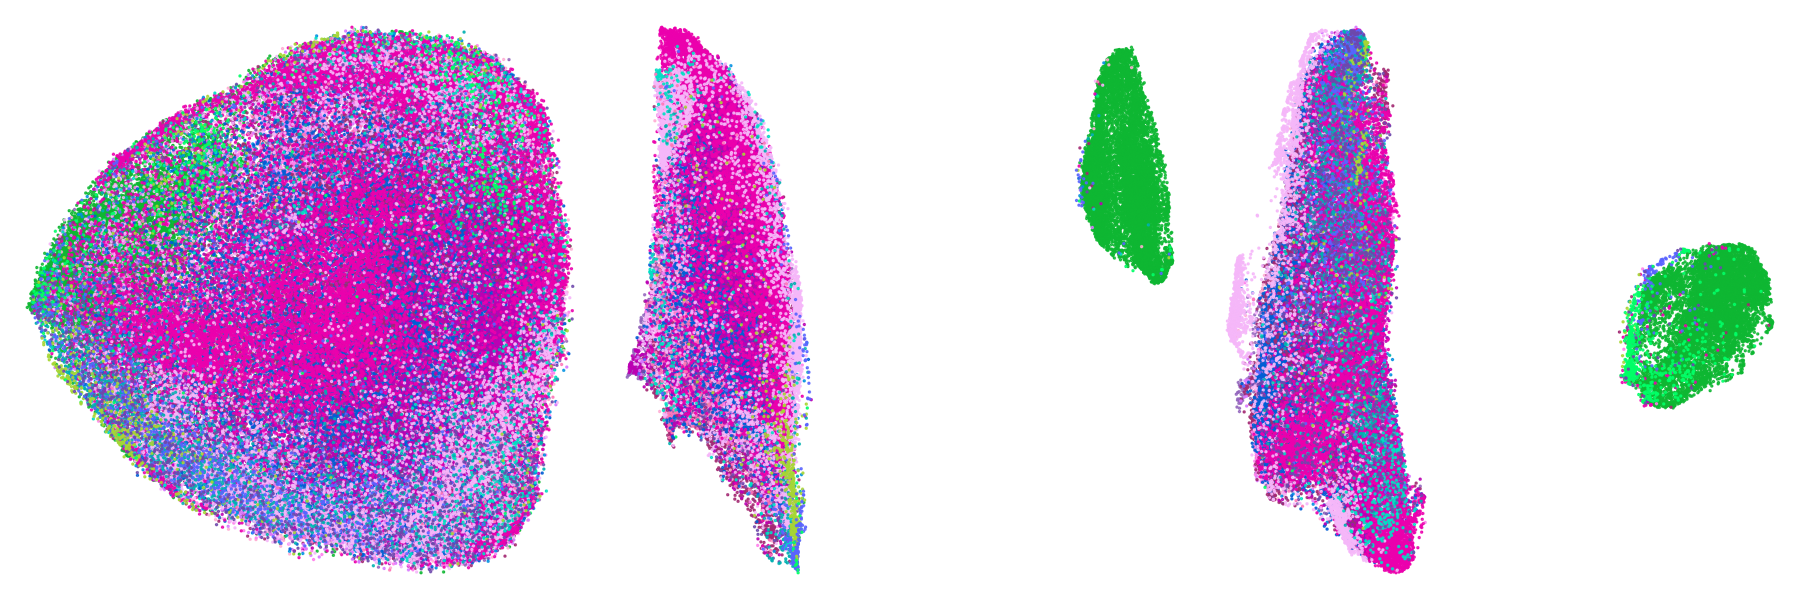

In [784]:
t0 <- rumap %>%
ggplot(aes(x = umap_1, y = umap_2, color = region)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_void() + 
scale_color_manual(values = col2) + NoLegend()

t1 <- d1$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = region)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_void() + 
scale_color_manual(values = col2) + NoLegend()

t2 <- d2$obs %>%
ggplot(aes(x = UMAP.1, y = UMAP.2, color = region)) + 
geom_point(size = 0.3, alpha = 0.8) + 
theme_void() + 
scale_color_manual(values = col2) + NoLegend()

options(repr.plot.width = 15, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t0, t1, t2, ncol = 3)
fig1

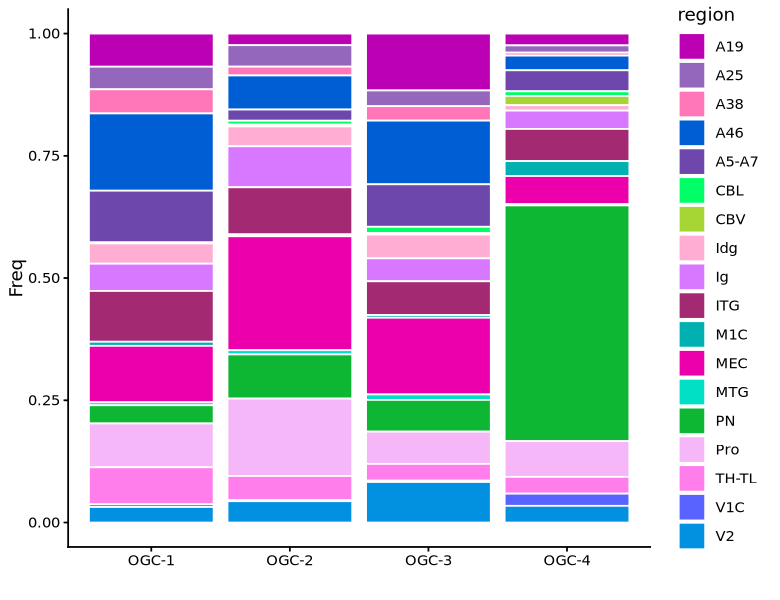

In [152]:
t1 <- robj@meta.data[,c("region", "cluster_manual_name")] %>%
table %>% as.data.frame %>% 
ggplot(aes(x = cluster_manual_name, y = Freq, fill = region)) + 
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + 
scale_fill_manual(values = col2)

options(repr.plot.width = 6.5, repr.plot.height = 5)
t1

### Plot differential cCREs and motifs

In [336]:
acvar <- readRDS("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250601.chromvar.rds")
mevar <- readRDS("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.chromvar.rds")

In [337]:
library(JASPAR2022)
library(TFBSTools)

# Get all CORE motifs
human_motifs <- getMatrixSet(JASPAR2022::JASPAR2022, opts = list(species = "Homo sapiens")) #, collection = "CORE"))
hmotif <- lapply(human_motifs, function(x) x@name) %>% unlist %>% as.character
validm1 <- intersect(hmotif, rownames(acvar)) %>% unique
validm2 <- c(intersect(hmotif, rownames(mevar))) %>% unique

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Matrix’:

    Matrix




In [307]:
acde <- read.csv("DESeq/OGC/structure_H3K27ac_ccre.csv")[,1:5] %>% 
setNames(c("feature", "logfc", "pval", "padj", "cluster"))
head(acde)

,feature,logfc,pval,padj,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1:153535224-153535723,1.868829,2.242256e-08,0.0007821886,Cerebellum
2,chr16:67249778-67250277,4.453792,3.666874e-07,0.0046769507,Cerebellum
3,chr9:100352089-100352588,2.038754,4.022145e-07,0.0046769507,Cerebellum
4,chr2:51032014-51032513,1.939219,9.277993e-07,0.0080913376,Cerebellum
5,chr1:230392645-230393144,1.605795,2.363445e-06,0.0125116035,Cerebellum
6,chr11:67071623-67072122,2.623717,2.510642e-06,0.0125116035,Cerebellum


In [309]:
cpm1 <- read.table("OGC_heterogenity/OGC_structure_H3K27ac.cCREs.cpm", sep = "\t", row.names = 1, header = T)
cpm2 <- read.table("OGC_heterogenity/OGC_structure_H3K27me3.cCREs.cpm", sep = "\t", row.names = 1, header = T)

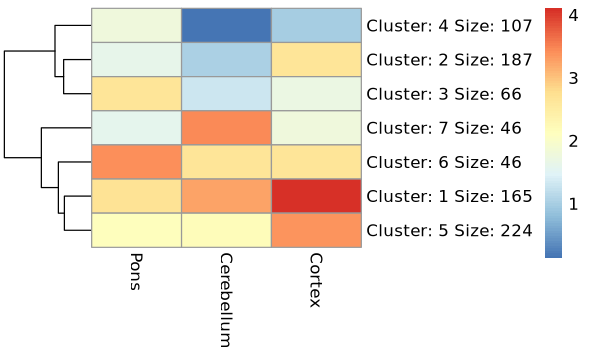

In [318]:
qfeature <- acde %>% 
filter(padj < 0.05, logfc >= 1) %>% 
select(feature) %>% unlist %>% as.character %>% unique
mtx <- log2(cpm1[qfeature,]+1)

kn <- 7
set.seed(921)

options(repr.plot.width = 5, repr.plot.height = 3)
d1 <- mtx %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>%
mutate(kmeansk = factor(kmeansk, levels = c(3,4,6,7,1,2,5))) %>%
arrange(kmeansk)

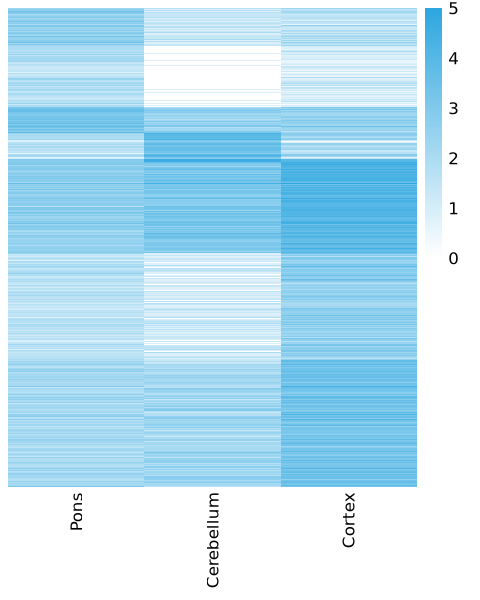

In [322]:
options(repr.plot.width = 4, repr.plot.height = 5)
fig1 <- mtx[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, # gaps_row = cumsum(table(qorder$kmeansk)), 
         border_color = NA, show_colnames = T, show_rownames = F, breaks = seq(0, 5, 0.05),
         angle_col = 90, color = colorRampPalette(c("white", "#2EA7E0"))(100))
         # color = colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50))

In [338]:
### For chromvar: use simple diff test rather than edgeR
f <- 'OGC'
qcell <- acvar@meta.data %>% filter(subclass_corrected == f) %>% rownames
acvar <- subset(acvar, cells = qcell)

Idents(acvar) <- "structure"
aresult <- FindAllMarkers(acvar, only.pos = F, mean.fxn = rowMeans, features = validm1,
                          fc.name = "avg_diff", min.pct = 0.05)

Calculating cluster Cerebellum

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Calculating cluster Cortex

Calculating cluster Pons



In [719]:
### Jointly filtered with gene expression
qgene <- aresult %>% filter(p_val_adj < 0.01, avg_diff > 0) %>%
select(gene) %>% unlist %>% as.character %>% unique

qmtx <- aresult %>% filter(gene %in% qgene, gene %in% rownames(rpkm)) %>%
reshape2::dcast(gene ~ cluster, value.var = "avg_diff") %>%
tibble::column_to_rownames("gene")
qmtx[is.na(qmtx)] <- 0

qgene <- rownames(qmtx)[rowSums(rpkm[rownames(qmtx),]) >= 0.5]

In [359]:
### Calculate aggregtaed motifs z score
obj_mtx <- acvar[["RNA"]]@data
group.by = "structure"
meta = acvar@meta.data

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "TsparseMatrix")
obj_mtx_collapse <- OP2(obj_mtx)
spars <- length(obj_mtx_collapse@x)/obj_mtx_collapse@Dim[1]/obj_mtx_collapse@Dim[2]
cat(paste0("sparsity: ", spars, "\n"))
if (spars > 0.2) {
    obj_mtx_collapse <- as(obj_mtx_collapse, "matrix")
    cat("coarse dgTMatrix into Matrix.\n")
}

ccount <- table(meta[, group.by]) %>% as.data.frame %>% tibble::column_to_rownames("Var1")
obj_mtx_collapse <- t(t(obj_mtx_collapse)/(ccount[colnames(obj_mtx_collapse),]))

sparsity: 0.966257668711656
coarse dgTMatrix into Matrix.


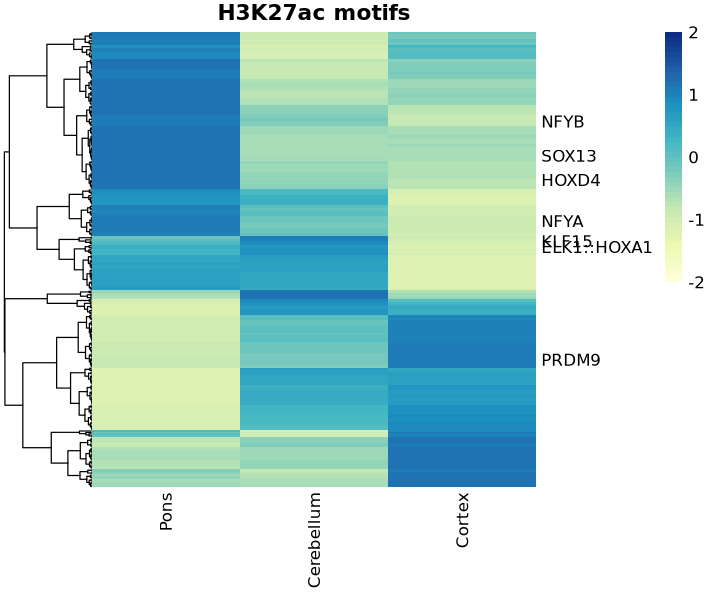

In [362]:
qfeature <- c('ELK1::HOXA1', 'HOXD4', 'NFYA', 'NFYB', 'SOX13', 'KLF15', 'PRDM9')

qgene <- aresult %>% filter(p_val_adj < 0.01, avg_diff > 0.1) %>% select(gene) %>% unlist %>% as.character %>% unique
smat1 <- obj_mtx_collapse[qgene,]
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

qlabel <- rownames(smat1)
qlabel[!(qlabel %in% qfeature)] <- ""

set.seed(921)
options(repr.plot.width = 6, repr.plot.height = 5)
t1 <- smat1 %>%
pheatmap(cluster_rows = T, cluster_cols = F, scale = "row", angle_col = 90,
         labels_row = qlabel, 
         breaks = seq(-2, 2, 0.08), main = "H3K27ac motifs", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

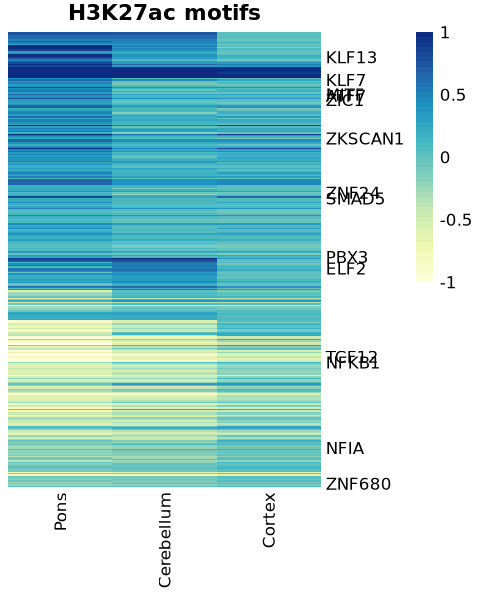

In [373]:
genede <- read.table("../04.clustering/02.RNA/edgeR_250808/subclass_corrected_edgeR_OGC_vs_all.tsv")
tgene <- genede %>%
filter(FDR < 0.01, logFC >= 1, logCPM >= 5) %>% rownames

qlabel <- rownames(smat1)
qlabel[!(qlabel %in% intersect(tgene, rownames(smat2)))] <- ""

options(repr.plot.width = 4, repr.plot.height = 5)
t1 <- smat1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90,
         labels_row = qlabel, 
         breaks = seq(-1, 1, 0.04), main = "H3K27ac motifs", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

### Also calculated for H3K27me3

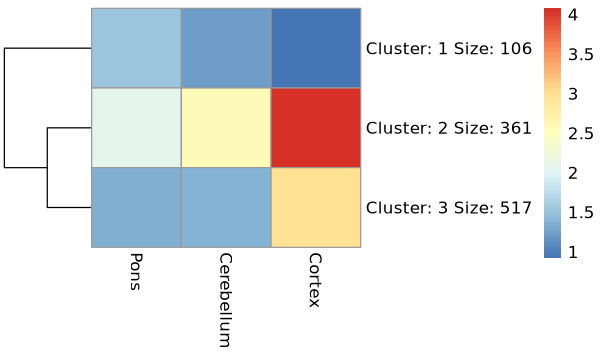

In [327]:
qfeature <- me3de %>% 
filter(padj < 0.05, logfc >= 1) %>% 
select(feature) %>% unlist %>% as.character %>% unique
mtx <- log2(cpm2[qfeature,]+1)

set.seed(921)
kn <- 3

options(repr.plot.width = 5, repr.plot.height = 3)
d1 <- mtx %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>%
mutate(kmeansk = factor(kmeansk, levels = c(2,3,1))) %>%
arrange(kmeansk)

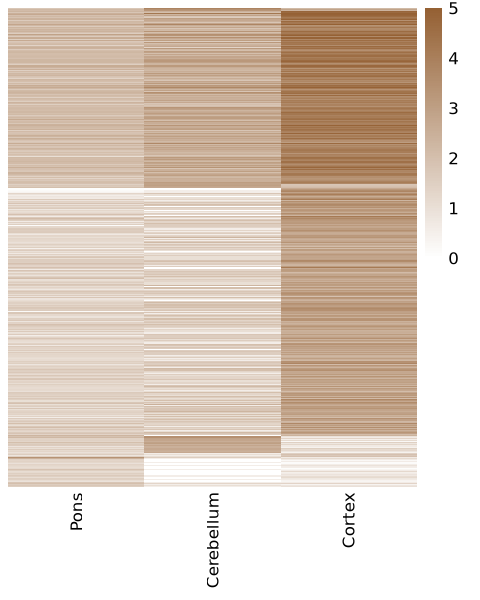

In [328]:
options(repr.plot.width = 4, repr.plot.height = 5)
fig1 <- mtx[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, #gaps_row = cumsum(table(qorder$kmeansk)), 
         border_color = NA, show_colnames = T, show_rownames = F, breaks = seq(0, 5, 0.05),
         angle_col = 90, color = colorRampPalette(c("white", "#956134"))(100))
         # color = colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50))

In [403]:
f <- 'OGC'
qcell <- mevar@meta.data %>% filter(subclass_corrected == f) %>% rownames
mevar <- subset(mevar, cells = qcell)

Idents(mevar) <- "structure"
aresult <- FindAllMarkers(mevar, only.pos = F, mean.fxn = rowMeans, features = validm2,
                          fc.name = "avg_diff", min.pct = 0.05)

Calculating cluster Cerebellum

Calculating cluster Cortex

Calculating cluster Pons



In [760]:
### Jointly filtered with gene expression
qgene <- aresult %>% filter(p_val_adj < 0.01) %>%
select(gene) %>% unlist %>% as.character %>% unique

qmtx <- aresult %>% filter(gene %in% qgene, gene %in% rownames(rpkm)) %>%
reshape2::dcast(gene ~ cluster, value.var = "avg_diff") %>%
tibble::column_to_rownames("gene")
qmtx[is.na(qmtx)] <- 0

qgene <- rownames(qmtx)[rowSums(rpkm[rownames(qmtx),]) >= 0.3]

In [406]:
### Calculate aggregtaed motifs z score
obj_mtx <- mevar[["RNA"]]@data
group.by = "structure"
meta = mevar@meta.data

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "TsparseMatrix")
obj_mtx_collapse <- OP2(obj_mtx)
spars <- length(obj_mtx_collapse@x)/obj_mtx_collapse@Dim[1]/obj_mtx_collapse@Dim[2]
cat(paste0("sparsity: ", spars, "\n"))
if (spars > 0.2) {
    obj_mtx_collapse <- as(obj_mtx_collapse, "matrix")
    cat("coarse dgTMatrix into Matrix.\n")
}

ccount <- table(meta[, group.by]) %>% as.data.frame %>% tibble::column_to_rownames("Var1")
obj_mtx_collapse <- t(t(obj_mtx_collapse)/(ccount[colnames(obj_mtx_collapse),]))

sparsity: 0.966257668711656
coarse dgTMatrix into Matrix.


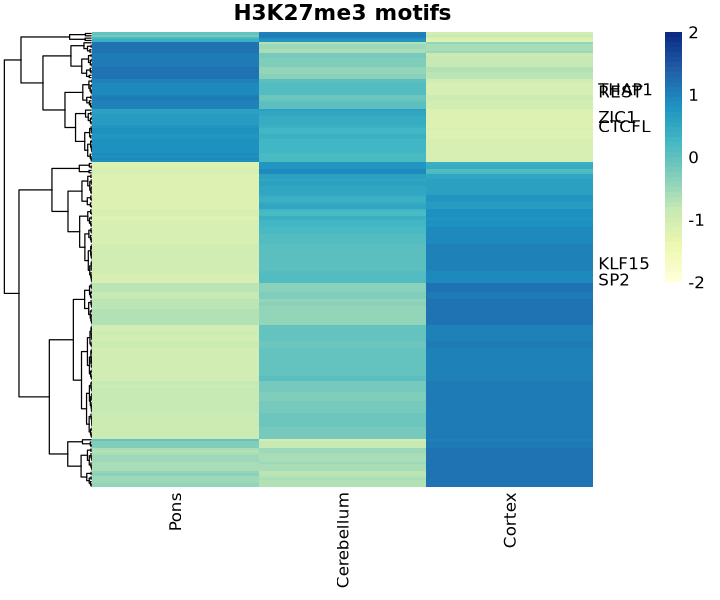

In [413]:
qgene <- aresult %>% filter(p_val_adj < 0.01, avg_diff > 0.1) %>% select(gene) %>% unlist %>% as.character %>% unique
smat1 <- obj_mtx_collapse[qgene,]
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

qlabel <- rownames(smat1)
qlabel[!(qlabel %in% qfeature)] <- ""

set.seed(921)
options(repr.plot.width = 6, repr.plot.height = 5)
t1 <- smat1 %>%
pheatmap(cluster_rows = T, cluster_cols = F, scale = "row", angle_col = 90,
         labels_row = qlabel, 
         breaks = seq(-2, 2, 0.08), main = "H3K27me3 motifs", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

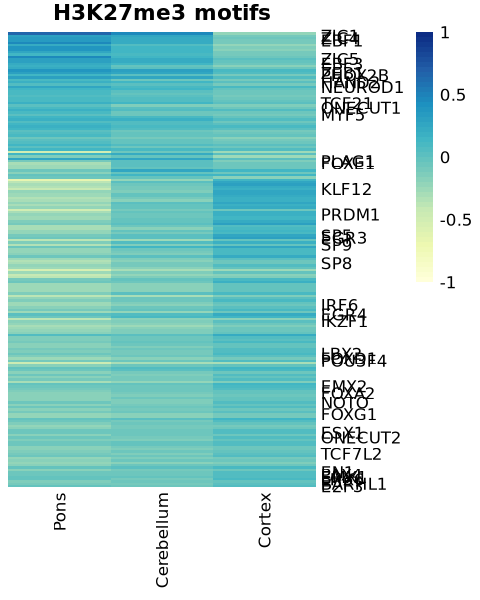

In [418]:
qqg <- elist2 %>% filter(mod == "H3K27me3") %>%
filter(FDR < 0.01, logFC >= 1) %>% 
filter(celltype == "OGC", region == "Cortex") %>% 
select(gene) %>% unlist %>% as.character

qlabel <- rownames(smat1)
qlabel[!(qlabel %in% intersect(qqg, rownames(smat1)))] <- ""

options(repr.plot.width = 4, repr.plot.height = 5)
t1 <- smat1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90,
         labels_row = qlabel, 
         breaks = seq(-1, 1, 0.04), main = "H3K27me3 motifs", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 